In [ ]:
# Install library yang diperlukan
import tensorflow as tf
!pip install tensorflow scikit-learn matplotlib

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Model
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import cv2
from skimage.feature import hog
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_acne = '/content/drive/MyDrive/PDM/BIASA/train/acne'
path_eksim = '/content/drive/MyDrive/PDM/BIASA/train/eksim'
path_herpes = '/content/drive/MyDrive/PDM/BIASA/train/herpes'
path_panu = '/content/drive/MyDrive/PDM/BIASA/train/panu'
path_rosacea = '/content/drive/MyDrive/PDM/BIASA/train/rosacea'

image augmentation

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,     # membagi dataset menjadi dua bagian
    rotation_range=30,        # Rotasi gambar hingga 40 derajat
    width_shift_range=0.2,    # Geser gambar secara horizontal
    height_shift_range=0.2,   # Geser gambar secara vertikal
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Zoom in/out
    horizontal_flip=True,     # Membalik gambar secara horizontal
    fill_mode='nearest',      # Mengisi pixel yang hilang

)


load data dari direktori

In [ ]:
 # Data pelatihan
train_data = datagen.flow_from_directory(
    directory='/content/drive/MyDrive/PDM/BIASA/train',
    classes=['acne', 'eksim', 'herpes','panu','rosacea'],  # Menentukan kelas
    target_size=(128, 128),  # Ukuran gambar
    batch_size=32,  # Jumlah gambar dalam setiap batch
    class_mode='binary',  # Klasifikasi biner
    subset='training'  # Subset data pelatihan
)

# Data validasi
valid_data = datagen.flow_from_directory(
    directory='/content/drive/MyDrive/PDM/BIASA/train',
    classes=['acne', 'eksim', 'herpes','panu','rosacea'],  # Menentukan kelas
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Subset data validasi
)

# Menampilkan kelas dan label
print(train_data.class_indices)

Found 328 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
{'acne': 0, 'eksim': 1, 'herpes': 2, 'panu': 3, 'rosacea': 4}


visualisasi **data**

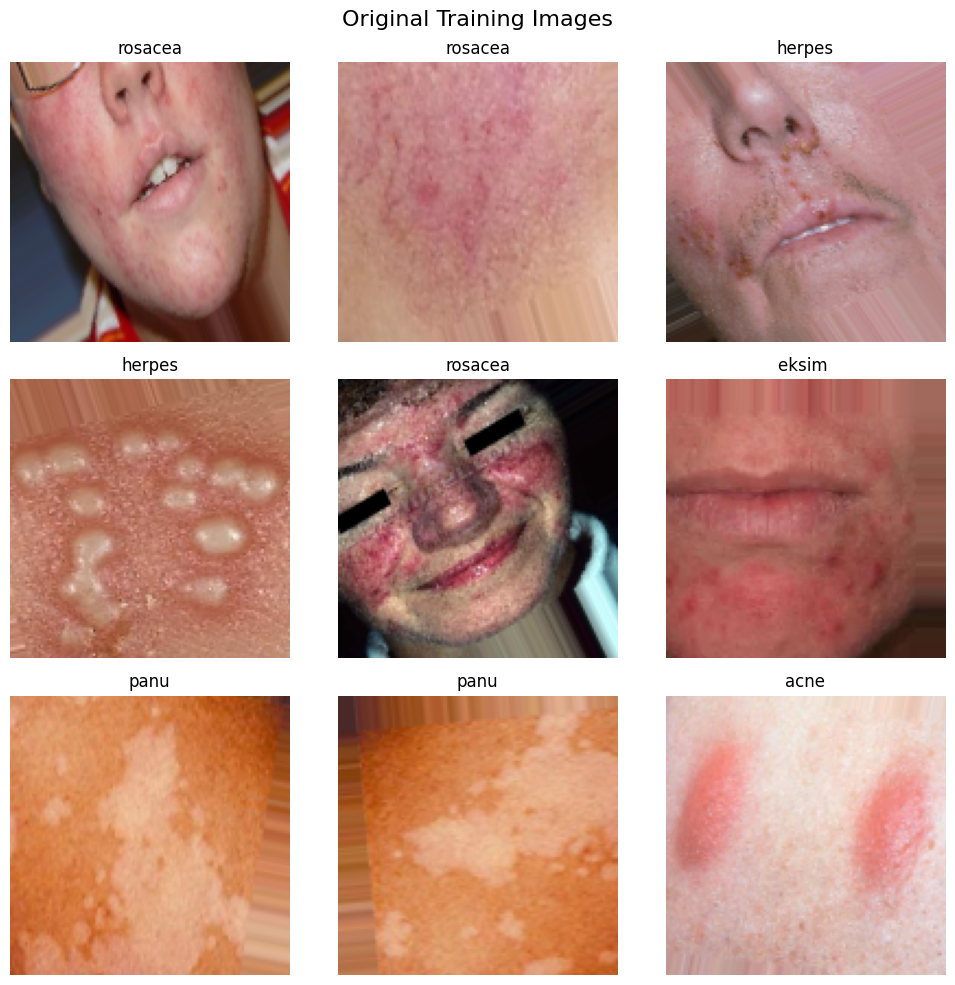

In [ ]:
# Ambil batch pertama dari original_data
images, labels = next(train_data)

# Daftar nama kelas
class_names = ['acne', 'eksim ', 'herpes','panu','rosacea']

# Visualisasi gambar asli dari train set
plt.figure(figsize=(10, 10))
for i in range(9):  # Menampilkan 9 gambar pertama
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])  # Gambar asli
    label_index = int(labels[i])  # Pastikan index dalam bentuk integer
    plt.title(class_names[label_index])  # Menampilkan nama kelas
    plt.axis('off')

plt.suptitle("Original Training Images", fontsize=16)
plt.tight_layout()
plt.show()


cek jumlah sampel

In [ ]:
# Menampilkan jumlah sampel dalam subset training dan validation
print("Jumlah sampel dalam data pelatihan:", train_data.samples)
print("Jumlah sampel dalam data validasi:", valid_data.samples)

Jumlah sampel dalam data pelatihan: 328
Jumlah sampel dalam data validasi: 80


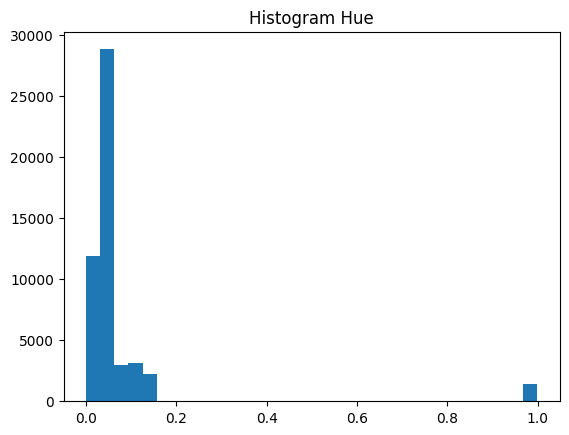

In [ ]:
from skimage import io, color
# Ambil satu gambar dari dataset
image_path = '/content/drive/MyDrive/PDM/BIASA/train/eksim/ek79_jpg.rf.32bb4ec9540923ab29a0beed766ad14f.jpg'  # Ganti dengan path gambar Anda
image = io.imread(image_path)

# Konversi ke ruang warna HSV
hsv_image = color.rgb2hsv(image)

# Hitung histogram untuk saluran Hue (warna)
plt.hist(hsv_image[:, :, 0].ravel(), bins=32)
plt.title('Histogram Hue')
plt.show()

In [ ]:
from skimage.feature import graycomatrix, graycoprops

# Konversi gambar ke grayscale
gray_image = color.rgb2gray(image)

# Konversi gambar grayscale ke tipe data unsigned integer 8-bit
gray_image = (gray_image * 255).astype(np.uint8) # Mengubah tipe data gambar grayscale

# Hitung GLCM
glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

# Hitung fitur tekstur (misal: contrast)
contrast = graycoprops(glcm, 'contrast')[0, 0]
print(f"Contrast: {contrast}")

Contrast: 28.819862211368562


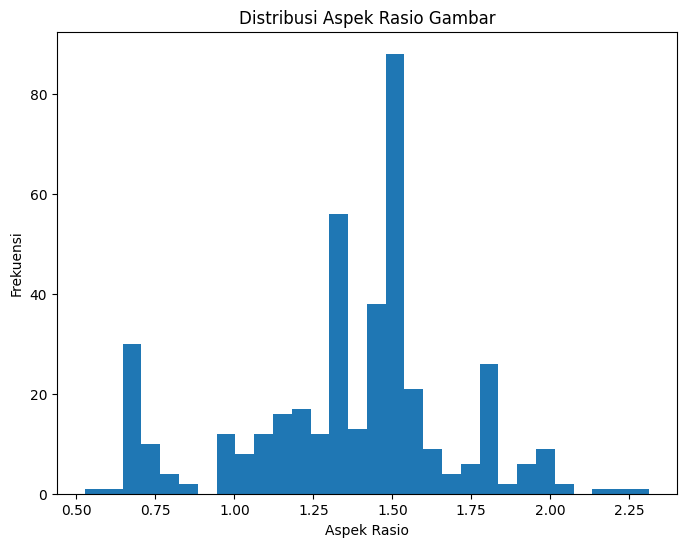

Aspek rasio rata-rata: 1.37
Aspek rasio standar deviasi: 0.33


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Path ke direktori dataset
dataset_path = '/content/drive/MyDrive/PDM/BIASA/train'

# Inisialisasi list untuk menyimpan aspek rasio gambar
aspect_ratios = []

# Iterasi melalui semua gambar dalam dataset
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        with Image.open(image_path) as img:
            width, height = img.size
            aspect_ratios.append(width / height)

# Visualisasi distribusi aspek rasio gambar
plt.figure(figsize=(8, 6))
plt.hist(aspect_ratios, bins=30)
plt.title('Distribusi Aspek Rasio Gambar')
plt.xlabel('Aspek Rasio')
plt.ylabel('Frekuensi')
plt.show()

# Menampilkan statistik aspek rasio gambar
print(f"Aspek rasio rata-rata: {np.mean(aspect_ratios):.2f}")
print(f"Aspek rasio standar deviasi: {np.std(aspect_ratios):.2f}")

# **Feature Extraction & Feature Selection**

In [ ]:
# Fungsi untuk mengekstrak HOG dari gambar
def extract_hog_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize gambar menjadi ukuran tetap (misalnya 128x128)
    image_resized = cv2.resize(image, (128, 128))
    # Ekstrak HOG dari gambar
    features, _ = hog(image_resized, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

# Tentukan path ke direktori gambar
image_dir = '/content/drive/MyDrive/PDM/BIASA/train'
# Daftar gambar dan label
image_paths = []
labels = []

# Mengasumsikan direktori gambar terstruktur berdasarkan kelas (misalnya acne, eczema, dll.)
classes = os.listdir(image_dir)

for class_name in classes:
    class_folder = os.path.join(image_dir, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        image_paths.append(img_path)
        labels.append(class_name)

# Ekstraksi fitur HOG untuk setiap gambar
features = [extract_hog_features(img) for img in image_paths]
# Mapping kelas ke label numerik
class_mapping = {class_name: idx for idx, class_name in enumerate(classes)}
labels_numeric = [class_mapping[label] for label in labels]

In [ ]:
# Membagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(features, labels_numeric, test_size=0.2, random_state=42)
# Konversi ke array NumPy
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [ ]:
# Inisialisasi model MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

# Preprocessing data
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/PDM/BIASA/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Ekstraksi fitur
features = base_model.predict(generator)
labels = generator.classes


Found 408 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


### **# seleksi fitur**

In [ ]:
#seleksi fitur menggunakan metode univariate selection
selector = SelectKBest(score_func=f_classif, k=20)
selected_features = selector.fit_transform(features, labels)

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif

# Misalnya features adalah DataFrame
selector = SelectKBest(score_func=f_classif, k=20)
selector.fit(features, labels)

# Dapatkan mask fitur yang terpilih
mask = selector.get_support()

# Indeks fitur yang terpilih
selected_feature_indices = np.where(mask)[0]

print("Fitur yang terpilih (indeks):")
print(selected_feature_indices)

Fitur yang terpilih (indeks):
[ 106  119  175  291  422  424  455  513  534  558  603  773  806  852
  880 1014 1024 1098 1122 1152]


#Modeling

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, test_size=0.2, random_state=42)

# Inisialisasi dan latih model
model = GaussianNB()
model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5975609756097561
Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       0.20      0.12      0.15        16
           2       0.47      0.53      0.50        15
           3       0.82      0.82      0.82        17
           4       0.47      0.50      0.49        18

    accuracy                           0.60        82
   macro avg       0.56      0.60      0.58        82
weighted avg       0.56      0.60      0.58        82



In [ ]:
import joblib

# Simpan model ke dalam file
joblib.dump(model, 'modelGNB_kondisi_kulit.pkl')
print("Model telah disimpan.")


Model telah disimpan.
